# # London Crime MLP Classifier
# Predicting **Crime type** using TensorFlow/Keras Multi-Layer Perceptron Neural Network

In [1]:
# Libraries

import os
import io
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, Flatten, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2
import seaborn as sns

2025-12-21 15:35:16.414788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-21 15:35:16.484648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 15:35:18.028086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Class Declaration

In [2]:
def save_model_checkpoint(model, epoch_label, save_path="Model"):
    os.makedirs(save_path, exist_ok=True)
    model.save(os.path.join(save_path, f"model_epoch_{epoch_label}.h5"))
    model.save_weights(os.path.join(save_path, f"weights_epoch_{epoch_label}.h5"))
    print(f"[✓] Saved model at epoch {epoch_label}")

 ## GPU Acceleration Pre-Training Hardware Verification

In [3]:
# GPU Configuration
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) configured: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, running on CPU")

# Disable mixed precision entirely (float32 is safest)
mixed_precision.set_global_policy('float32')

print("Mixed precision disabled. Using float32 for all ops.")


TensorFlow version: 2.20.0
Num GPUs Available:  1
GPU(s) configured: ['/physical_device:GPU:0']
Mixed precision disabled. Using float32 for all ops.


 ## Load Dataset

In [4]:
# Step 1: Memory-Efficient Data Preprocessing (Chunked CSV → HDF5)
input_csv = "Dataset/mergedCRDataset.csv"
preprocessed_hdf5_file = "Dataset/Preprocessed/MergedCRDataset.h5"
os.makedirs(os.path.dirname(preprocessed_hdf5_file), exist_ok=True)

chunksize = 1_000_000
chunk_idx = 0

numeric_cols = ['Longitude', 'Latitude']
categorical_cols = ['Reported by', 'Falls within']
target_col = 'Crime type'
group_col = 'LSOA name'

 ## Data Preprocessing

In [5]:
# Open an HDF5 file to store the processed data
with h5py.File(preprocessed_hdf5_file, 'w') as hdf5_file:
    # Create datasets for storing features and targets
    X_all = []
    y_all = []
    
    for chunk in pd.read_csv(input_csv, sep="\t", engine="python", on_bad_lines="skip", chunksize=chunksize):
        # Strip column names
        chunk.columns = chunk.columns.str.strip()

        # --- Print summary for this chunk ---
        summary = pd.DataFrame({
            "missing": chunk.isna().sum(),
            "non_missing": chunk.notna().sum(),
            "total": len(chunk)
        })
        print(f"\nChunk {chunk_idx} summary:")
        print(summary)

        # Drop duplicates and unnecessary columns
        chunk.drop_duplicates(inplace=True)
        if "Crime ID" in chunk.columns:
            chunk.drop(columns=["Crime ID"], inplace=True)

        # Fill numeric NaNs using group medians
        group_medians = chunk.groupby(group_col)[numeric_cols].median()
        chunk = chunk.merge(group_medians, left_on=group_col, right_index=True, how='left', suffixes=('', '_grp'))
        for col in numeric_cols:
            chunk[col] = chunk[col].fillna(chunk[f'{col}_grp'])
        global_medians = chunk[numeric_cols].median()
        chunk[numeric_cols] = chunk[numeric_cols].fillna(global_medians)
        chunk.drop(columns=[f'{c}_grp' for c in numeric_cols], inplace=True)

        # Encode target
        chunk[target_col] = chunk[target_col].astype('category')
        chunk['target_encoded'] = chunk[target_col].cat.codes

        # Convert categorical features to category dtype
        for col in categorical_cols:
            chunk[col] = chunk[col].astype('category')

        # --- Print target counts for monitoring ---
        print(f"Chunk {chunk_idx} target value counts:")
        print(chunk[target_col].value_counts())

        # Prepare data for saving
        X_chunk = chunk[numeric_cols + categorical_cols]
        y_chunk = chunk['target_encoded']
        
        # Add to lists for saving later in the HDF5 file
        X_all.append(X_chunk)
        y_all.append(y_chunk)

        chunk_idx += 1
        
    # Stack all chunks into a single array
    X_all = pd.concat(X_all, ignore_index=True)
    y_all = pd.concat(y_all, ignore_index=True)

    print("\nTotal number of samples:", X_all.shape[0])

    # Convert everything to string first (prevents dtype O issues)
    X_all = X_all.astype(str)

    # Label encode each column
    for col in X_all.columns:
        le = LabelEncoder()
        X_all[col] = le.fit_transform(X_all[col])

    # Convert to HDF5-safe arrays
    X_np = X_all.to_numpy(dtype='float32')
    y_np = y_all.to_numpy(dtype='int32')

    # -----------------------------------------------------------------------

    # Store in HDF5
    hdf5_file.create_dataset('X', data=X_np)
    hdf5_file.create_dataset('y', data=y_np)




Chunk 0 summary:
                       missing  non_missing    total
Crime ID                128008       871992  1000000
Month                        0      1000000  1000000
Reported by                  0      1000000  1000000
Falls within                 0      1000000  1000000
Longitude                17593       982407  1000000
Latitude                 17593       982407  1000000
Location                     0      1000000  1000000
LSOA code                31373       968627  1000000
LSOA name                31373       968627  1000000
Outcome type            700659       299341  1000000
Crime type              299341       700659  1000000
Last outcome category   436597       563403  1000000
Context                1000000            0  1000000
Chunk 0 target value counts:
Crime type
Violence and sexual offences    239049
Anti-social behaviour            71511
Public order                     58456
Criminal damage and arson        55822
Other theft                      52460
Vehic

 ## Train/Test Split

In [6]:
# Step 2: Load Preprocessed Data, Scaling & One-Hot Encoding
# Load data from HDF5
with h5py.File(preprocessed_hdf5_file, 'r') as hdf5_file:
    X = hdf5_file['X'][:]
    y = hdf5_file['y'][:]

# Scale numeric features
scaler = StandardScaler()
X[:, :len(numeric_cols)] = scaler.fit_transform(X[:, :len(numeric_cols)])

# One-hot encode target
y = to_categorical(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

num_classes = y.shape[1]

Training samples: 24581180, Testing samples: 6145295


 ## Model Definition

In [7]:
# Enable multi-GPU training
strategy = tf.distribute.MirroredStrategy()

print("Available GPUs:", strategy.num_replicas_in_sync)

with strategy.scope():
    model = Sequential()

    model.add(Input(
        shape=X_train.shape[1:]))

    # Add L2 regularization to first dense layer
    model.add(Dense(
        128, 
        activation='relu',
        kernel_regularizer=l2(0.0005)   # <<< L2 penalty
    ))

    model.add(Dense(
        64, 
        activation='relu',
        kernel_regularizer=l2(0.0001)   # <<< L2 penalty
    ))

        # Add L2 regularization to output layer
    model.add(Dense(
        y.shape[1],
        activation='softmax'))

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')]
    )

model.summary()

save_path = 'Model'
os.makedirs(save_path, exist_ok=True)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


I0000 00:00:1766332255.900907   12900 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21087 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9


Available GPUs: 1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,806 (38.30 KB)

 Trainable params: 9,806 (38.30 KB)

 Non-trainable params: 0 (0.00 B)

 ## Training

In [8]:
epoch_intervals = [50]
previous_epochs = 0

stage_histories = {}   # <- save history per stage

for target_epochs in epoch_intervals:
    epochs_to_run = target_epochs - previous_epochs

    print(f"\nTraining to reach {target_epochs} total epochs "
          f"({epochs_to_run} new epochs)...")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs_to_run,
        batch_size=4096,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=50,
                min_lr=1e-7
            )
        ]
    )

    # Save history for this stage
    stage_histories[f"up_to_{target_epochs}_epochs"] = history.history

    #
    save_model_checkpoint(model, target_epochs, save_path="Model")

    # Update counter
    previous_epochs = target_epochs



Training to reach 50 total epochs (50 new epochs)...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/

2025-12-21 15:51:34.438623: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-21 15:51:34.438740: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


6002/6002 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.6118 - loss: 1.8439 - precision: 0.6312 - recall: 0.4003 - val_accuracy: 0.6448 - val_loss: 1.5228 - val_precision: 0.6444 - val_recall: 0.5631 - learning_rate: 1.0000e-05
Epoch 2/50


2025-12-21 15:51:41.044476: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4963 - precision: 0.6441 - recall: 0.6150 - val_accuracy: 0.6448 - val_loss: 1.4815 - val_precision: 0.6451 - val_recall: 0.6433 - learning_rate: 1.0000e-05
Epoch 3/50


2025-12-21 15:52:14.708569: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


6002/6002 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6448 - loss: 1.4767 - precision: 0.6450 - recall: 0.6439 - val_accuracy: 0.6448 - val_loss: 1.4732 - val_precision: 0.6448 - val_recall: 0.6448 - learning_rate: 1.0000e-05
Epoch 4/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6448 - loss: 1.4716 - precision: 0.6448 - recall: 0.6448 - val_accuracy: 0.6448 - val_loss: 1.4702 - val_precision: 0.6448 - val_recall: 0.6448 - learning_rate: 1.0000e-05
Epoch 5/50


2025-12-21 15:53:21.685092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4694 - precision: 0.6448 - recall: 0.6448 - val_accuracy: 0.6448 - val_loss: 1.4684 - val_precision: 0.6448 - val_recall: 0.6448 - learning_rate: 1.0000e-05
Epoch 6/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6448 - loss: 1.4679 - precision: 0.6449 - recall: 0.6446 - val_accuracy: 0.6448 - val_loss: 1.4672 - val_precision: 0.6453 - val_recall: 0.6441 - learning_rate: 1.0000e-05
Epoch 7/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6448 - loss: 1.4668 - precision: 0.6458 - recall: 0.6434 - val_accuracy: 0.6448 - val_loss: 1.4662 - val_precision: 0.6467 - val_recall: 0.6423 - learning_rate: 1.0000e-05
Epoch 8/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4659 - precision: 0.6475 - recall: 0.6414 - val_accuracy: 0.6448 - val_loss: 1.4654 - val_precision: 0.6482 - val_recall: 0.6407 - learning_rate: 1.0000e-05
Epoch 9/50


2025-12-21 15:55:35.816710: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4652 - precision: 0.6483 - recall: 0.6406 - val_accuracy: 0.6448 - val_loss: 1.4648 - val_precision: 0.6483 - val_recall: 0.6406 - learning_rate: 1.0000e-05
Epoch 10/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4645 - precision: 0.6485 - recall: 0.6404 - val_accuracy: 0.6448 - val_loss: 1.4642 - val_precision: 0.6485 - val_recall: 0.6404 - learning_rate: 1.0000e-05
Epoch 11/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4639 - precision: 0.6486 - recall: 0.6403 - val_accuracy: 0.6448 - val_loss: 1.4636 - val_precision: 0.6486 - val_recall: 0.6403 - learning_rate: 1.0000e-05
Epoch 12/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6448 - loss: 1.4634 - precision: 0.6486 - recall: 0.6403 - val_accuracy: 0.6448 - val_loss: 1.4631 - val_precision: 0.6487 - val_recall: 0.6402 - learning_rate: 1.0000e-05
Epoch 13/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 3

2025-12-21 16:00:04.598488: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


6002/6002 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6448 - loss: 1.4613 - precision: 0.6494 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4611 - val_precision: 0.6494 - val_recall: 0.6399 - learning_rate: 1.0000e-05
Epoch 18/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4610 - precision: 0.6494 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4607 - val_precision: 0.6494 - val_recall: 0.6399 - learning_rate: 1.0000e-05
Epoch 19/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4606 - precision: 0.6494 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4604 - val_precision: 0.6494 - val_recall: 0.6398 - learning_rate: 1.0000e-05
Epoch 20/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4604 - precision: 0.6494 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4601 - val_precision: 0.6494 - val_recall: 0.6398 - learning_rate: 1.0000e-05
Epoch 21/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 3

2025-12-21 16:09:04.812301: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4582 - precision: 0.6495 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4580 - val_precision: 0.6495 - val_recall: 0.6398 - learning_rate: 1.0000e-05
Epoch 34/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4581 - precision: 0.6495 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4579 - val_precision: 0.6494 - val_recall: 0.6398 - learning_rate: 1.0000e-05
Epoch 35/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4580 - precision: 0.6495 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4578 - val_precision: 0.6495 - val_recall: 0.6398 - learning_rate: 1.0000e-05
Epoch 36/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6448 - loss: 1.4578 - precision: 0.6495 - recall: 0.6399 - val_accuracy: 0.6448 - val_loss: 1.4578 - val_precision: 0.6495 - val_recall: 0.6399 - learning_rate: 1.0000e-05
Epoch 37/50
6002/6002 ━━━━━━━━━━━━━━━━━━━━ 3

ValueError: The filename must end in `.weights.h5`. Received: filepath=Model/weights_epoch_50.h5

In [9]:
# --- Save staged training history ---
history_file = os.path.join(save_path, 'staged_training_history.pkl')
with open(history_file, 'wb') as f:
    pickle.dump(stage_histories, f)

# --- Save the full model and weights ---
model_file = os.path.join(save_path, 'my_model.h5')
weights_file = os.path.join(save_path, 'my_model_weights.h5')

model.save(model_file)
model.save_weights(weights_file)

print(f"Staged training history saved to {history_file}")
print(f"Model saved to {model_file}")
print(f"Weights saved to {weights_file}")


ValueError: The filename must end in `.weights.h5`. Received: filepath=Model/my_model_weights.h5

Evaluation Defnition

In [10]:
# --- Generate predictions for evaluation ---
y_probs = model.predict(X_test)                    # Probabilities
y_pred_classes = np.argmax(y_probs, axis=1)        # Predicted labels
y_true_classes = np.argmax(y_test, axis=1)         # True labels

# For compatibility with later code:
all_true = y_true_classes
all_preds = y_pred_classes
all_probs = y_probs

192041/192041 ━━━━━━━━━━━━━━━━━━━━ 757s 4ms/step


Evaluation

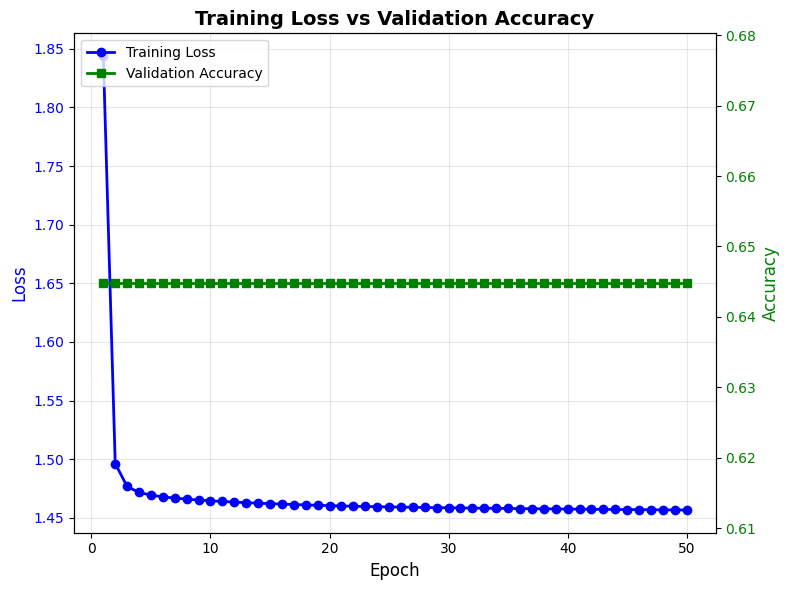

192041/192041 ━━━━━━━━━━━━━━━━━━━━ 753s 4ms/step
Accuracy score: 0.6448012666601034
[[0.06694269 0.00351564 0.01937028 0.04354358 0.0211992  0.012729
  0.03288861 0.0047652  0.05122183 0.00356624 0.03395885 0.0028488
  0.02053853 0.6829115 ]
 [0.05550095 0.00506492 0.02695041 0.04669756 0.0171384  0.0133723
  0.03762537 0.00615979 0.04724757 0.00648222 0.04477441 0.00472581
  0.03350747 0.65475285]
 [0.0623911  0.00756088 0.02579268 0.03406353 0.01765915 0.00822997
  0.0527777  0.00379746 0.03473629 0.01085307 0.03918378 0.01852287
  0.039916   0.6445154 ]
 [0.09048121 0.00569505 0.01770068 0.05375874 0.01395388 0.00987135
  0.0383027  0.00553016 0.045275   0.00308725 0.04299857 0.00232525
  0.01950517 0.65151507]
 [0.05585419 0.00668946 0.02393319 0.04096717 0.01677302 0.01007423
  0.04168386 0.00563835 0.04563173 0.00664986 0.05060726 0.00602971
  0.03870163 0.65076643]]
[13 13 13 ... 13 13 13]


In [11]:
# Track loss and accuracy for visualization
loss_across_epochs = history.history['loss']
val_accuracy_across_epochs = history.history['val_accuracy']
# Visualization (example for Training Loss vs Validation Accuracy)
fig, ax = plt.subplots(figsize=(8, 6))
epochs_range = range(1, len(loss_across_epochs) + 1)
ax_twin = ax.twinx()
line1 = ax.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2)
line2 = ax_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12, color='b')
ax_twin.set_ylabel('Accuracy', fontsize=12, color='g')
ax.tick_params(axis='y', labelcolor='b')
ax_twin.tick_params(axis='y', labelcolor='g')
ax.grid(True, alpha=0.3)
ax.set_title('Training Loss vs Validation Accuracy', fontsize=14, fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('model_training_performance.png', dpi=300, bbox_inches='tight')
plt.show()
#make predictions (will give a probability distribution)
pred_hot = model.predict(X_test)
#now pick the most likely outcome
pred = np.argmax(pred_hot,axis=1)
y_compare = np.argmax(y_test,axis=1) 
#calculate accuracy
score = metrics.accuracy_score(y_compare, pred)

print("Accuracy score: {}".format(score))

print(pred_hot[:5])
print(pred)

 ## Evaluation

In [12]:

num_classes = y.shape[1]

# --- Step 2: Classification report ---
print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION METRICS")
print("=" * 80)
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))
# --- Step 3: F1 Scores ---
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
print(f"\n1. F1 SCORES:")
print(f"   Macro F1 (treats all classes equally): {macro_f1:.4f}")
print(f"   Weighted F1 (accounts for class imbalance): {weighted_f1:.4f}")
# --- Step 4: Recall Scores ---
macro_recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
per_class_recall = recall_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
print(f"\n2. RECALL SCORES (Detection Rate):")
print(f"   Macro Recall: {macro_recall:.4f}")
print(f"   Weighted Recall: {weighted_recall:.4f}")
print(f"   Per-class Recall:")
for i, recall in enumerate(per_class_recall):
    print(f"      Class {i}: {recall:.4f}")
# --- Step 5: Confusion Matrix ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\n3. Confusion Matrix:")
print(cm)
# --- Step 6: AUROC / ROC-AUC ---
try:
    if num_classes == 2:
        auc = roc_auc_score(y_true_classes, y_probs[:, 1])
        print(f"\n4. AUROC / ROC-AUC Score:")
        print(f"   Binary AUC: {auc:.4f}")
    else:
        macro_auc = roc_auc_score(y_true_classes, y_probs, multi_class='ovr', average='macro')
        weighted_auc = roc_auc_score(y_true_classes, y_probs, multi_class='ovr', average='weighted')
        print(f"\n4. AUROC / ROC-AUC Score:")
        print(f"   Macro AUC (One-vs-Rest): {macro_auc:.4f}")
        print(f"   Weighted AUC: {weighted_auc:.4f}")
except Exception as e:
    print(f"\n4. AUROC / ROC-AUC:")
    print(f"   Could not compute AUC: {str(e)}")
# --- Step 7: Overall Accuracy ---
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\nOverall Accuracy: {accuracy:.4f}")
print("=" * 80)

COMPREHENSIVE MODEL EVALUATION METRICS

Classification Report:


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    393901
           1       0.00      0.00      0.00     35283
           2       0.00      0.00      0.00    144084
           3       0.00      0.00      0.00    275633
           4       0.00      0.00      0.00    109064
           5       0.00      0.00      0.00     72540
           6       0.00      0.00      0.00    264616
           7       0.00      0.00      0.00     32743
           8       0.00      0.00      0.00    261312
           9       0.00      0.00      0.00     44846
          10       0.00      0.00      0.00    269947
          11       0.00      0.00      0.00     71717
          12       0.00      0.00      0.00    207115
          13       0.64      1.00      0.78   3962494

    accuracy                           0.64   6145295
   macro avg       0.05      0.07      0.06   6145295
weighted avg       0.42      0.64      0.51   6145295


1. F1 SCORES:
   Macro F

# Data Analysis/Visualization

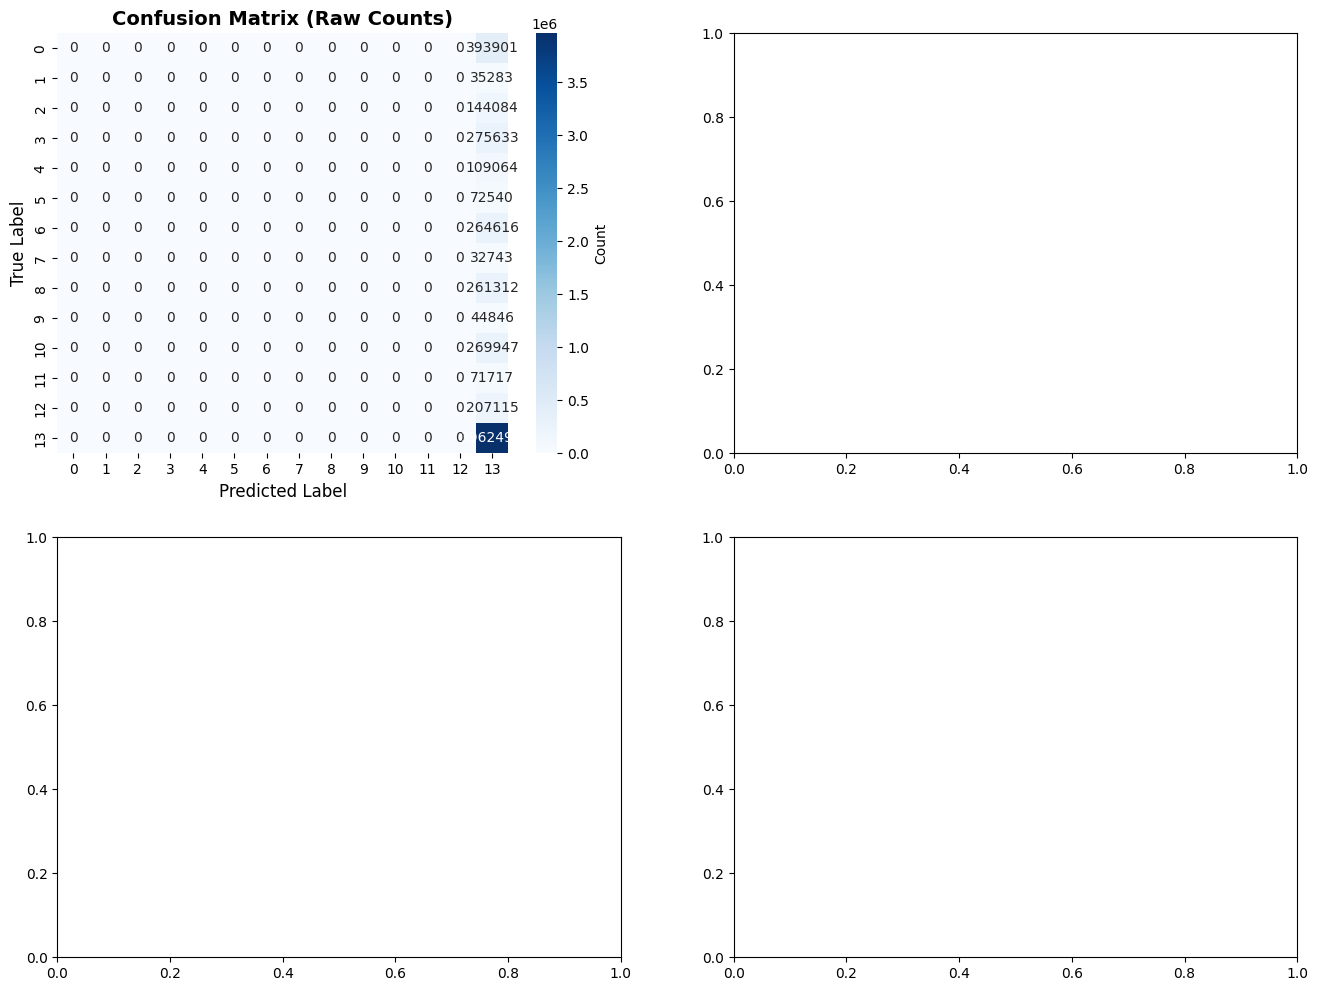

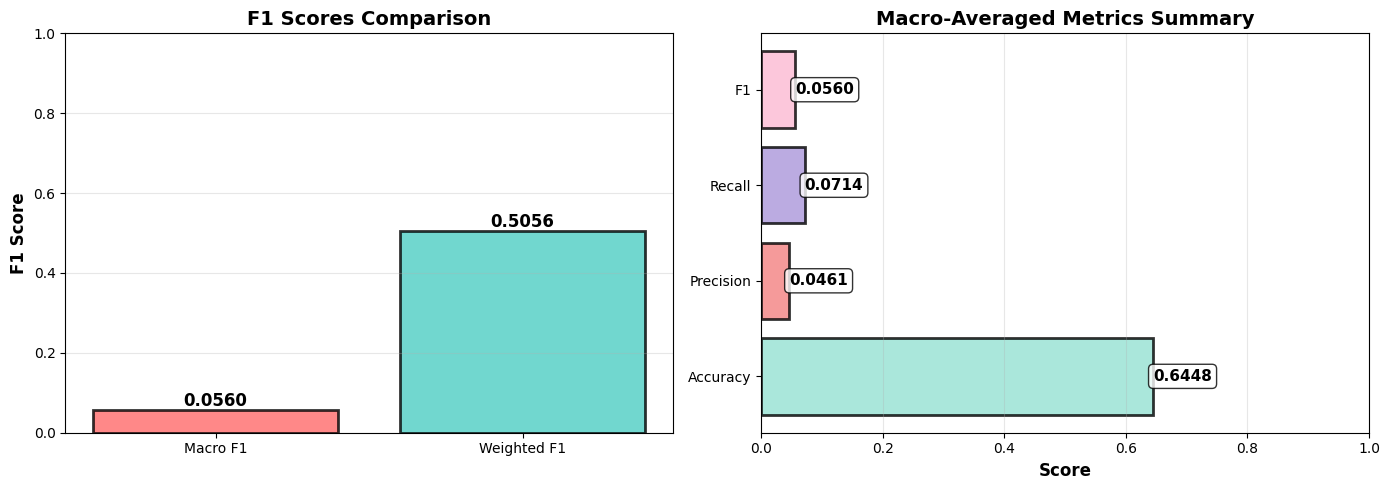

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [13]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)
# Additional metrics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. F1 Scores Comparison
ax1 = axes[0]
metrics = ['Macro F1', 'Weighted F1']
scores = [macro_f1, weighted_f1]
colors_metrics = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(metrics, scores, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Scores Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Macro Metrics Summary
ax2 = axes[1]
macro_precision = precision_score(all_true, all_preds, average='macro', zero_division=0)
summary_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
summary_values = [accuracy, macro_precision, macro_recall, macro_f1]
colors_summary = ['#95E1D3', '#F38181', '#AA96DA', '#FCBAD3']

bars = ax2.barh(summary_metrics, summary_values, color=colors_summary, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Macro-Averaged Metrics Summary', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
ax2.grid(True, alpha=0.3, axis='x')

for bar, value in zip(bars, summary_values):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f'{value:.4f}', ha='left', va='center', fontsize=11, fontweight='bold', 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()
# 2. Normalized Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Recall %'})
ax2.set_title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)
# 3. Training Loss and Validation Accuracy
ax3 = axes[1, 0]
epochs_range = range(1, len(loss_across_epochs) + 1)
ax3_twin = ax3.twinx()
line1 = ax3.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2, markersize=6)
line2 = ax3_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12, color='b')
ax3_twin.set_ylabel('Accuracy', fontsize=12, color='g')
ax3.tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='g')
ax3.grid(True, alpha=0.3)
ax3.set_title('Training Loss vs Validation Accuracy', fontsize=14, fontweight='bold')
# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left', fontsize=10)
# 4. Per-Class Recall Bar Chart
ax4 = axes[1, 1]
class_names = [f'Class {i}' for i in range(len(per_class_recall))]
colors = ['green' if r > 0.5 else 'orange' if r > 0.3 else 'red' for r in per_class_recall]
bars = ax4.bar(class_names, per_class_recall, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=macro_recall, color='r', linestyle='--', linewidth=2, label=f'Macro Recall: {macro_recall:.4f}')
ax4.set_ylabel('Recall', fontsize=12)
ax4.set_title('Per-Class Recall (Detection Rate)', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, recall in zip(bars, per_class_recall):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{recall:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
# ROC-AUC Curves (One-vs-Rest for multi-class)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# 1. ROC Curve (One-vs-Rest)
ax1 = axes[0]
if num_classes > 2:
    # Multi-class: use label binarization
    all_true_bin = label_binarize(all_true, classes=range(num_classes))
    
    colors = plt.cm.Set3(np.linspace(0, 1, num_classes))
    auc_scores = []
    
    for i in range(min(num_classes, 5)):  # Limit to 5 classes for clarity
        fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        ax1.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')
# Micro-average
    fpr, tpr, _ = roc_curve(all_true_bin.ravel(), all_probs.ravel())
    roc_auc_micro = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='deeppink', lw=3, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curves (One-vs-Rest) - Top 5 Classes', fontsize=13, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=9)
    ax1.grid(True, alpha=0.3)
else:
    # Binary classification
    fpr, tpr, _ = roc_curve(all_true, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=10)
    ax1.grid(True, alpha=0.3)
# 2. Per-Class Metrics Heatmap
ax2 = axes[1]
precision, recall, f1, support = precision_recall_fscore_support(all_true, all_preds, 
                                                                   average=None, zero_division=0)

metrics_data = np.array([precision, recall, f1]).T
im = ax2.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
# Set ticks and labels
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11, fontweight='bold')
ax2.set_yticks(range(min(len(precision), 10)))
ax2.set_yticklabels([f'Class {i}' for i in range(min(len(precision), 10))], fontsize=10)
ax2.set_title('Per-Class Metrics Heatmap (Top 10 Classes)', fontsize=13, fontweight='bold')
# Add text annotations
for i in range(min(len(precision), 10)):
    for j in range(3):
        text = ax2.text(j, i, f'{metrics_data[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('roc_and_metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()